In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from python.utils import *
from python.signal_processing import *
from python.post_processing import activations2beats
from python.models import TCN_Davies

In [6]:
# sr, signal = wavfile.read('/Users/juliusrichter/Documents/Uni/Masterarbeit/beat_tracker/data/audio/GTZAN/classical.00095.wav', mmap=False)
# mono_signal = remix(signal)

sr, signal = wavfile.read('/Users/juliusrichter/Desktop/bowie.wav', mmap=False)
mono_signal = remix(signal)

# sr, signal = wavfile.read('/Volumes/Transcend/Musik/Downloads/Merchant - Instant Funk.wav', mmap=False)
# signal = remix(signal)

In [7]:
sr = 44100
frame_size = 2048
frame_rate = 100
hop_size = sr/frame_rate
window = np.hamming(frame_size) 
num_fft_bins = frame_size >> 1 
bin_frequencies = np.fft.fftfreq(frame_size, 1. / sr)[:num_fft_bins]
filterbank = np.array(create_filterbank(bin_frequencies, num_fft_bins), dtype='float32')

In [8]:
nhid = 16
levels = 10
kernel_size = 5
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TCN_Davies(nhid, levels, kernel_size, dropout)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('../models/TCN_Davies_0254_0.2.pt', map_location=device))
model.eval();

In [10]:
start = time.time()
num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
frames = []    

# Slice audio into frames
for index in range(num_frames):
    frames.append(signal_frame(mono_signal, index, frame_size, hop_size))

# Compute FFT    
fft = np.empty((num_frames, num_fft_bins), np.complex64)
for f, frame in enumerate(frames):
    fft_signal = np.multiply(frame, window)
    fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins]

abs_fft = np.square(np.abs(fft))

filt_spec = np.log(np.dot(abs_fft, filterbank.T) + 1.0)
filt_spec = filt_spec[:,~np.all(filt_spec == 0, axis=0)]
input = torch.tensor(filt_spec, dtype=torch.float32) 


with torch.no_grad():        
    out = model(input.view(1, len(input),-1))
        

activations = np.exp(np.array(out[0,1,:]))

pred_beats = activations2beats(activations)

     
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))


Elapsed time: 0 min and 9 s


In [ ]:
signal = mono_signal / np.max(np.abs(mono_signal))
        
metronome = clicks(pred_beats[0::2], sr=sr, length=len(signal))

signal = signal + 0.4*metronome
signal = signal / np.max(np.abs(signal))
        
ipd.Audio(signal, rate=sr)

In [13]:
diff = np.diff(pred_beats)

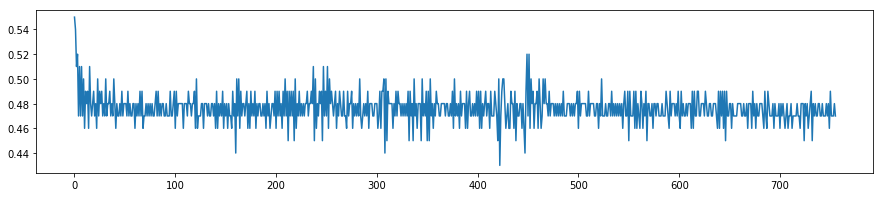

In [23]:
plt.figure(figsize=(15,3))
plt.plot(diff);